In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
LightGBM_results = pd.read_excel('LightGBM_results.xlsx')
LSTM_results = pd.read_excel('LSTM_results.xlsx')
Prophet_results = pd.read_excel('Prophet_results.xlsx')
SARIMA_results = pd.read_excel('SARIMA_results.xlsx')
XGBoost_results = pd.read_excel('XGBoost_results.xlsx')

In [3]:
LSTM_results.rename(columns={'Predicted':'predicted', 'Actual':'actual'}, inplace=True)
Prophet_results.rename(columns={'predicted_sales':'predicted', 'actual_sales':'actual'}, inplace=True)

In [4]:
lightgbm_forecasts = LightGBM_results[['predicted','actual']]
xgboost_forecasts = XGBoost_results[['predicted','actual']]
sarima_forecasts = SARIMA_results[['predicted','actual']]
prophet_forecasts = Prophet_results[['predicted','actual']]
LSTM_forecasts = LSTM_results[['predicted','actual']]

In [8]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def MAE(predictions, targets):
    return np.abs(predictions - targets).mean()

In [10]:
true_values = lightgbm_forecasts['actual']

In [11]:
predicted_values = {
    'LightGBM': lightgbm_forecasts['predicted'].values,
    'LSTM': LSTM_forecasts['predicted'].values,
    'Prophet': prophet_forecasts['predicted'].values,
    'SARIMA': sarima_forecasts['predicted'].values,
    'XGBoost': xgboost_forecasts['predicted'].values
}

In [13]:
best_rmse = float('inf')
best_mae = float('inf')
best_weights_rmse = {}
best_weights_mae = {}
best_preds_rmse = None
best_preds_mae = None

for weight1 in np.arange(0, 1.1, 0.2):
    for weight2 in np.arange(0, 1.1 - weight1, 0.2):
        for weight3 in np.arange(0, 1.1 - weight1 - weight2, 0.2):
            for weight4 in np.arange(0, 1.1 - weight1 - weight2 - weight3, 0.2):
                weight5 = 1.0 - weight1 - weight2 - weight3 - weight4
                combined_prediction = (weight1 * predicted_values['LightGBM'] + 
                                       weight2 * predicted_values['LSTM'] +
                                       weight3 * predicted_values['Prophet'] +
                                       weight4 * predicted_values['SARIMA'] +
                                       weight5 * predicted_values['XGBoost'])
        
                rmse = RMSE(combined_prediction, true_values)
                mae = MAE(combined_prediction, true_values)
        
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_weights_rmse = {
                        'LightGBM': weight1,
                        'LSTM': weight2,
                        'Prophet': weight3,
                        'SARIMA': weight4,
                        'XGBoost': weight5
                    }
                    best_preds_rmse = combined_prediction
                
                if mae < best_mae:
                    best_mae = mae
                    best_weights_mae = {
                        'LightGBM': weight1,
                        'LSTM': weight2,
                        'Prophet': weight3,
                        'SARIMA': weight4,
                        'XGBoost': weight5
                    }
                    best_preds_mae = combined_prediction


best_results_rmse = pd.DataFrame({
    'Actual': true_values,
    'Predicted (Best RMSE)': best_preds_rmse
})

best_results_mae = pd.DataFrame({
    'Actual': true_values,
    'Predicted (Best MAE)': best_preds_mae
})


In [14]:
best_results_rmse['date'] = LightGBM_results['date']
best_results_rmse['item_id'] = LightGBM_results['item_id']

In [15]:
best_results_rmse

,Actual,Predicted (Best RMSE),date,item_id
0,40,44.727045,2015-10-28,0
1,58,46.330231,2015-10-29,0
2,77,69.167734,2015-10-30,0
3,101,80.311901,2015-10-31,0
4,58,56.769117,2015-11-01,0
...,...,...,...,...
53995,2,11.297910,2016-04-20,299
53996,2,12.385193,2016-04-21,299
53997,1,14.123359,2016-04-22,299
53998,7,15.441299,2016-04-23,299


In [17]:
LightGBM_results_28 = pd.read_excel('LightGBM_results_28.xlsx')
LSTM_results_28 = pd.read_excel('LSTM_results_28.xlsx')
Prophet_results_28 = pd.read_excel('Prophet_results_28.xlsx')
SARIMA_results_28 = pd.read_excel('SARIMA_results_28.xlsx')
XGBoost_results_28 = pd.read_excel('XGBoost_results_28.xlsx')

In [18]:
LightGBM_predicted = LightGBM_results_28['predicted_sales']
LSTM_predicted = LSTM_results_28['Predicted']
SARIMA_predicted = SARIMA_results_28['predicted']
XGBoost_predicted = XGBoost_results_28['predicted']
Prophet_predicted = Prophet_results_28['yhat']

In [19]:
new_predicted_values = {
    'LightGBM': LightGBM_predicted,  
    'LSTM': LSTM_predicted,    
    'Prophet': Prophet_predicted, 
    'SARIMA': SARIMA_predicted, 
    'XGBoost': XGBoost_predicted  
}

ensemble_predictions_rmse = (best_weights_rmse['LightGBM'] * new_predicted_values['LightGBM'] +
                            best_weights_rmse['LSTM'] * new_predicted_values['LSTM'] +
                            best_weights_rmse['Prophet'] * new_predicted_values['Prophet'] +
                            best_weights_rmse['SARIMA'] * new_predicted_values['SARIMA'] +
                            best_weights_rmse['XGBoost'] * new_predicted_values['XGBoost'])

ensemble_predictions_mae = (best_weights_mae['LightGBM'] * new_predicted_values['LightGBM'] +
                            best_weights_mae['LSTM'] * new_predicted_values['LSTM'] +
                            best_weights_mae['Prophet'] * new_predicted_values['Prophet'] +
                            best_weights_mae['SARIMA'] * new_predicted_values['SARIMA'] +
                            best_weights_mae['XGBoost'] * new_predicted_values['XGBoost'])


In [26]:
results_df = pd.DataFrame({
    'date': LightGBM_results_28['date'],
    'Product_ID': LightGBM_results_28['item_id'],
    'predicted': ensemble_predictions_rmse,
    'actual': LightGBM_results_28['actual']
})

In [27]:
results_df_28 = results_df.dropna(subset=['date','predicted'])

In [28]:
results_df_28

,date,Product_ID,predicted,actual
0,2016-04-25,0,33.862493,48
1,2016-04-26,0,30.966535,35
2,2016-04-27,0,31.144880,34
3,2016-04-28,0,34.293438,67
4,2016-04-29,0,51.026691,63
...,...,...,...,...
8395,2016-05-18,299,10.816974,0
8396,2016-05-19,299,11.904257,5
8397,2016-05-20,299,13.491143,9
8398,2016-05-21,299,14.750475,5


In [149]:
results_df_28['predicted'].isnull().sum()

0

In [22]:
mae = mean_absolute_error(results_df_28['actual'], results_df_28['predicted'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(results_df_28['actual'], results_df_28['predicted'])

mse = mean_squared_error(results_df_28['actual'], results_df_28['predicted'])
rmse = sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 4.043427163317396
Root Mean Squared Error: 6.31377217545766


In [23]:

mae = mean_absolute_error(best_results_rmse['Actual'], best_results_rmse['Predicted (Best RMSE)'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(best_results_rmse['Actual'], best_results_rmse['Predicted (Best RMSE)'])

mse = mean_squared_error(best_results_rmse['Actual'], best_results_rmse['Predicted (Best RMSE)'])
rmse = sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 4.168920323087525
Root Mean Squared Error: 7.094890974207822


In [25]:
results_df_28.to_excel('ensemble_BMC.xlsx')

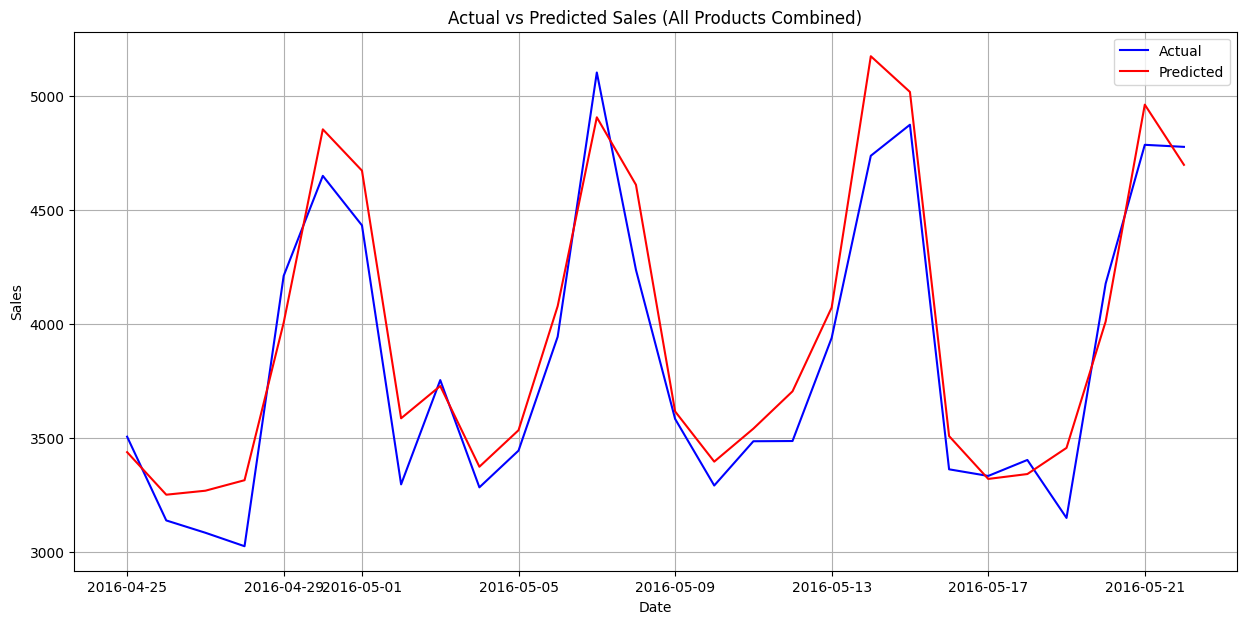

In [144]:
plt.figure(figsize=(15, 7))

results_df_28['date'] = pd.to_datetime(results_df_28['date'])

grouped = results_df_28.groupby('date').agg({
    'actual': 'sum',
    'predicted': 'sum'
}).reset_index()

plt.plot(grouped['date'], grouped['actual'], label='Actual', color='blue')
plt.plot(grouped['date'], grouped['predicted'], label='Predicted', color='red')

plt.legend() 
plt.xlabel('Date') 
plt.ylabel('Sales')  
plt.title('Actual vs Predicted Sales (All Products Combined)')
plt.grid(True)
plt.show()